# Simulating Poisson processes with thinning

Notebook written by [Manon Michel](manon.michel@uca.fr)

The goal here is to experiment around the thinning of inhomogeneous Poisson processes. A Poisson process of rate $\lambda(t)\leq \lambda_M, \forall t$ can be simulated by considering a bound homogeneous Poisson process of rate $\lambda_M$:

- starting at $\tau_{0}=0$
- generating the event time $\tau$ of the bound Poisson process of rate $\lambda_M$
- resampling this event as a true event with probability $\frac{\lambda(\tau+\tau_0)}{\lambda_M} $
- If $\tau+\tau_0$ is resampled as the event time of the true Poisson process, output $\tau+\tau_0$. If not, update $\tau_0 = \tau_0 + \tau$ and repeat the previous steps.

Refs:

(1) APA Lewis, P. A., & Shedler, G. S. (1979). Simulation of nonhomogeneous Poisson processes by thinning. Naval Research Logistics Quarterly, 26(3), 403-413.

Library importation

In [1]:
import numpy as np
import random, math
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
import matplotlib.lines as mlines
from matplotlib.ticker import FixedLocator

plt.rcParams['xtick.major.size'] = 8
plt.rcParams['xtick.minor.size'] = 8
plt.rcParams['ytick.major.size'] = 8
plt.rcParams['ytick.minor.size'] = 8

We consider the problem of simulating from the first event time of a non-homogenous Poisson process of rate $\lambda$:
$$\lambda(t) = max(\sin(t),0), \forall t\geq 0 $$

1. Find $\lambda_M$ such that $\lambda_M\geq \lambda(t), \forall t$
In the code below, please,
2. Assign a correct value to `self.lambda_M`
3. Code the `homogeneousPP_generation` routine which outputs the first event time of a Poisson process of homogeneous rate `self.lambda_M` by inversion sampling
4. Code the `thinning_generation` routine which outputs the first event time of the inhomogeneous Poisson process of rate $\lambda(t)$ (given by the routine `lambda_rate`) by thinning using the PP of rate $\lambda_M$
5. Code the `theoretical_arrival` routine which outputs the probability of a given time to be the first event time of the target inhomogeneous PP


Theoretical Answers:

1) We have that $\lambda(t) = \max(\sin(t), 0) \leq 1, \forall t \geq 0$, we can therefore set $\lambda_{M} = 1$.

2) We can simply initialize by setting $\lambda_{M} = 1$ in the __init__ function.

3) The first event time of a Poisson process of homogeneous rate is an exponential random variable of same rate. Let $X \sim \mathcal{E}(\lambda_{M})$, we can simulate this random variable by inversion sampling. Let us first compute the inverse of its cumulative distribution:

$$
F_{X}(x) = \int_{0}^{x} \lambda_{M}e^{-\lambda_{M}s}ds = 1 - e^{-\lambda_{M}x}
$$

$$
F_{X}^{-1}(x) = - \frac{1}{\lambda_{M}} \log(1 - x)
$$

Using the fact that $X\sim \mathcal{U}([0,1])\sim - X$ have the same law, we can therefore perform the inversion sampling using $U \sim \mathcal{U}([0,1])$

$$
T = -\frac{1}{\lambda_{M}} \log(U)
$$

4) Find the implementation below.

5) For each time $t$ this is exactly, up to a normalization factor:

$$
f(t) = \lambda(t) e^{-\lambda(t)t}
$$


In [15]:
class max_cos_PP:
    def __init__(self,lambda_M = 1):
        # Parameter initialization
        self.lambda_M = lambda_M
    
    def lambda_rate(self,t):
        return max(0,math.sin(t))
    
    def homogeneousPP_generation(self):
        # Write a routine generating the event times of the
        # homogeneous PP of rate lambda_M
        
        U = np.random.random()
        
        return - np.log(U) / self.lambda_M
        
    def direct_generation(self):
        # Routine generating by inversion the event times
        # of the PP of rate lambda    
        ran_tot = -math.log(random.uniform(0.0,1.0))
        tau = 2.0 * math.pi * (ran_tot//2)
        ran_tot = ran_tot % 2.0
        tau +=  math.acos(1-ran_tot)
        return tau
        
    def thinning_generation(self):
        # Write a routine generating the event times of the
        # PP of rate lambda by thinning
        
        tau0 = 0
        tau = self.homogeneousPP_generation()
        
        while np.random.random() > self.lambda_rate(tau + tau0) / self.lambda_M:
            tau0 += tau
            tau = self.homogeneousPP_generation()
            
        return tau + tau0
            
    def theoretical_arrival(self,t):
        # Write a routine generating the probability 
        # value for t to be the first arrival time 
        # of the target PP
        lamb = self.lambda_rate(t)
        return lamb * np.exp(-lamb*t)

6. Compare the normed histograms of the first event times obtained with the `direct_generation`(directly sampling by inversion of the inhomogeneous PP), the `thinning_generation` and the theoretical value. Compare to the normed histogram of the first event times of the bound homogeneous PP of rate $\lambda_M$.

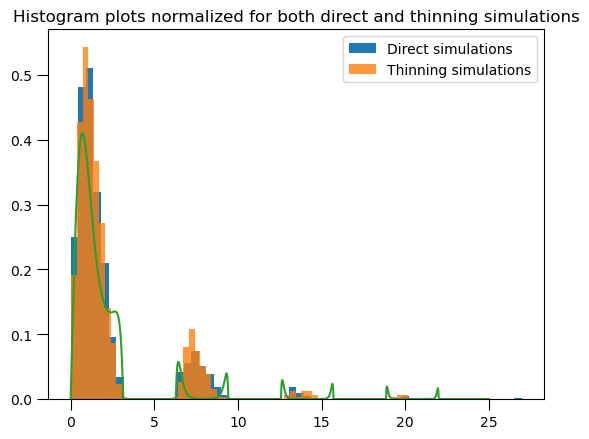

In [30]:
N = 1000

direct_simulations = np.zeros(N)
thinning_simulations = np.zeros(N)
proc = max_cos_PP()

for i in range(N):
    direct_simulations[i] = proc.direct_generation()
    thinning_simulations[i] = proc.thinning_generation()
    
xs = np.linspace(0, 25, 10000)
theoretical = [proc.theoretical_arrival(x) for x in xs]

plt.hist(direct_simulations, label = 'Direct simulations', density=True, bins = 60)
plt.hist(thinning_simulations, label = 'Thinning simulations', density=True, bins = 60, alpha = 0.8)
plt.plot(xs, theoretical)
plt.title('Histogram plots normalized for both direct and thinning simulations')
plt.legend()
plt.show()

7. Compare the cumulative histograms of the first event times obtained with the `direct_generation`(directly sampling by inversion of the inhomogeneous PP), the `thinning_generation` and the theoretical values. Compare also to the cumulative histogram of the first event times of the bound homogeneous PP of rate $\lambda_M$. Confirm why the thinning method is correct.

8. How is the number of generated bound events required to resample a true one behaving with $\lambda_M$? Please, provide a plot.
9. What is a good choice for $\lambda_M$? (the smallest one!)

We consider the problem of simulating from the first event time of a non-homogenous Poisson process of rate $\lambda$:
$$\lambda(t) = t, \forall t\geq 0 $$

10. This cannot be bounded by a homogeneous rate. What alternative strategy could you think of?

In the code below, please,

11. Code the `lambda_M_rate` routine which outputs the rate at time t of the inhomongeneous bound PP

12. Code the `bound_PP_generation` routine which outputs by inversion sampling the first event time of a Poisson process whose rate $\lambda_M(t)$ bounds $\lambda$ 

13. Code the `thinning_generation` routine which outputs the first event time of the inhomogeneous Poisson process of rate $\lambda(t)$ (given by the routine `lambda_rate`) by thinning using the inhomogeneous PP of rate $\lambda_M$

14. Code the `theoretical_target_arrival` routine which outputs the probability of a given time to be the first event time of the target inhomogeneous PP

15. Code the `theoretical_bound_arrival` routine which outputs the probability of a given time to be the first event time of the target bound inhomogeneous PP


Answer:

10) We can propose a $\lambda_{M}$ that changes with time

In [232]:
class linear_PP:
    def __init__(self,T_M):
        # Parameter initialization
        self.T_M = T_M
    
    def lambda_rate(self,t):
        return t
        
    def lambda_M_rate(self,t):
        return 
    
    def bound_PP_generation(self,tau_0):
        # Write a routine generating the event times of the
        # inhomogeneous PP of rate lambda_M
        return
        
    def direct_generation(self):
        # Routine generating by inversion the event times
        # of the PP of rate lambda    
        ran_tot = -math.log(random.uniform(0.0,1.0))
        tau = (2.0 * ran_tot)**0.5
        return tau
        
    def thinning_generation(self):
        # Write a routine generating the event times of the
        # PP of rate lambda by thinning
        return
            
    def theoretical_bound_arrival(self,t):
        # Write a routine generating the probability 
        # value for t to be the first arrival time 
        # of the bound PP
        return       
            
    def theoretical_target_arrival(self,t):   
        # Write a routine generating the probability 
        # value for t to be the first arrival time 
        # of the target PP   
        return 

13. Compare the normed histograms of the first event times obtained with the `direct_generation`(directly sampling by inversion of the inhomogeneous PP), the `thinning_generation` and the theoretical values. Compare to the normed histogram of the event times of the inhomogeneous bound PP of rate $\lambda_M$ and to the theoretical values for the bound PP.

6. Validate the thinning strategy by comparing the cumulative histograms and theoretical values of the first event times obtained with the `direct_generation`(directly sampling by inversion of the inhomogeneous PP), the `thinning_generation` and  of the bound homogeneous PP of rate $\lambda_M$.